In [1]:
%matplotlib inline
import os, shutil
import sys
sys.path.append("..")
import numpy as np
from IPython.display import Image
import pandas as pd
import matplotlib.pyplot as plt

import flopy as flopy
import pyemu

In [2]:
import freyberg_setup as fs
working_dirs = [fs.WORKING_DIR_UN,fs.WORKING_DIR_KR,fs.WORKING_DIR_ZN,
               fs.WORKING_DIR_PP,fs.WORKING_DIR_GR]
pst_names = [fs.PST_NAME_UN,fs.PST_NAME_KR,fs.PST_NAME_ZN,
             fs.PST_NAME_PP,fs.PST_NAME_GR]
setup_functions = [fs.setup_pest_un,fs.setup_pest_kr,fs.setup_pest_zn,
                   fs.setup_pest_pp,fs.setup_pest_gr]
num_workers = [1,1,1,10,20]

In [3]:
for setup_function in setup_functions:
    setup_function()

['botm.ref', 'extract_zone_array.py', 'forecasts_true.csv', 'freyberg.bas', 'freyberg.dbf', 'freyberg.dis', 'freyberg.hds', 'freyberg.heads', 'freyberg.heads_potobs.ins', 'freyberg.hyd', 'freyberg.list', 'freyberg.locations', 'freyberg.mpbas', 'freyberg.mpenpt', 'freyberg.mplist', 'freyberg.mpnam', 'freyberg.mppthln', 'freyberg.mpsim', 'freyberg.oc', 'freyberg.pcg', 'freyberg.rivflux', 'freyberg.shp', 'freyberg.shx', 'freyberg.travel', 'freyberg.truth.lpf', 'freyberg.truth.nam', 'freyberg.truth.rch', 'freyberg.truth.riv', 'freyberg.truth.wel', 'hk.truth.ref', 'hk.zones', 'ibound.ref', 'kzone.ref', 'mpath.in', 'obs_loc.csv', 'potobs_group.csv', 'Process_output.py', 'run_true_model.py', 'strt.ref', 'Weights_and_best_PHI.xlsx']

changing model workspace...
   freyberg_un
FloPy is using the following executable to run the model: E:\git\GW1876\activities\freyberg_summary\freyberg_un\mfnwt.exe

                                  MODFLOW-NWT-SWR1 
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFF

## FOSM comparison

First run all the cases with ``noptmax``= -1

In [4]:
for nw, pst_name, wd in zip(num_workers,pst_names,working_dirs):
    pst = pyemu.Pst(os.path.join(wd,pst_name))
    if pst_name == fs.PST_NAME_KR:
        pst.parameter_data.loc["rch_0","partrans"] = "none"
    pst.control_data.noptmax = -1
    pst.write(os.path.join(wd,pst_name))
    print(pst_name)
    #cwd = os.getcwd()
    #os.chdir(wd)
    #try:
    pyemu.helpers.start_slaves(wd,"pestpp",pst_name,num_slaves=nw,master_dir=wd+"_master")
    #except:
    #    os.chdir(cwd)
    #    break
    #os.chdir(cwd)

freyberg_un.pst
master:pestpp freyberg_un.pst /h :4004 in freyberg_un_master
slave:pestpp freyberg_un.pst /h localhost:4004 in ..\slave_0
freyberg_kr.pst
master:pestpp freyberg_kr.pst /h :4004 in freyberg_kr_master
slave:pestpp freyberg_kr.pst /h localhost:4004 in ..\slave_0
freyberg_zn.pst
master:pestpp freyberg_zn.pst /h :4004 in freyberg_zn_master
slave:pestpp freyberg_zn.pst /h localhost:4004 in ..\slave_0
freyberg_pp.pst
master:pestpp freyberg_pp.pst /h :4004 in freyberg_pp_master
slave:pestpp freyberg_pp.pst /h localhost:4004 in ..\slave_0
slave:pestpp freyberg_pp.pst /h localhost:4004 in ..\slave_1
slave:pestpp freyberg_pp.pst /h localhost:4004 in ..\slave_2
slave:pestpp freyberg_pp.pst /h localhost:4004 in ..\slave_3
slave:pestpp freyberg_pp.pst /h localhost:4004 in ..\slave_4
slave:pestpp freyberg_pp.pst /h localhost:4004 in ..\slave_5
slave:pestpp freyberg_pp.pst /h localhost:4004 in ..\slave_6
slave:pestpp freyberg_pp.pst /h localhost:4004 in ..\slave_7
slave:pestpp freyberg

Now loop through each ``master`` dir and construct a ``pyemu.Schur`` instance

In [5]:
schurs = []
for pst_name,wd in zip(pst_names,working_dirs):
    parcov = None
    if pst_name == fs.PST_NAME_PP:
        parcov = fs.build_prior_pp()
    elif pst_name == fs.PST_NAME_GR:
        parcov = fs.build_prior_gr()
    sc = pyemu.Schur(jco=os.path.join(wd+"_master",pst_name.replace(".pst",".jcb")),parcov=parcov)
    schurs.append(sc)

E:\miniconda\lib\site-packages\pandas\core\indexing.py:288: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
E:\miniconda\lib\site-packages\pandas\core\indexing.py:465: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [6]:
prior,post,percent = [],[],[]
for schur in schurs:
    fc = schur.get_forecast_summary()
    prior.append(fc.loc[:,"prior_var"])
    post.append(fc.loc[:,"post_var"])
    percent.append(fc.loc[:,"percent_reduction"])
names = [pst.split('.')[0].split('_')[1] for pst in pst_names]    
prior = pd.concat(prior,axis=1).apply(np.sqrt)
prior.columns = names
post = pd.concat(post,axis=1).apply(np.sqrt)
post.columns = names
percent = pd.concat(percent,axis=1)
percent.columns = names


In [26]:
forecasts = list(prior.index.values)
wl_forecasts = [f for f in forecasts if f.startswith("fr")] 
rflx_forecast = [f for f in forecasts if f.startswith("fl")][0]
tt_forecast = "travel_time"
forecasts = [wl_forecasts,rflx_forecast,tt_forecast]
titles = ["water level","SW-GW exchange","travel time"]

### Prior uncertainty

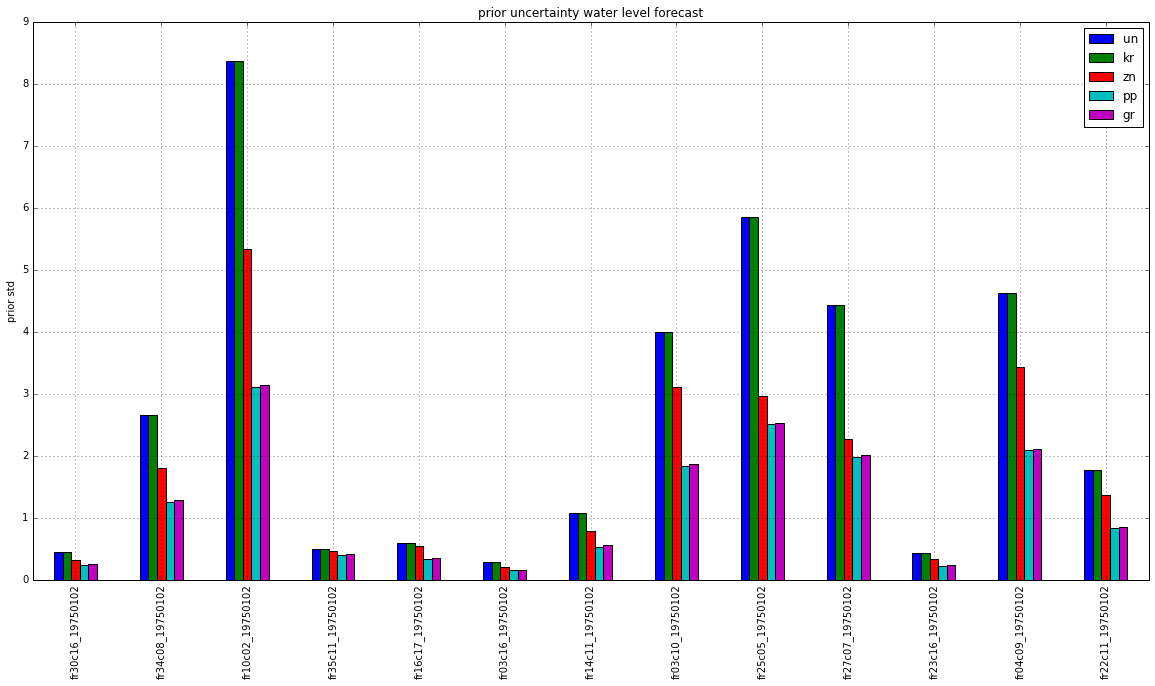

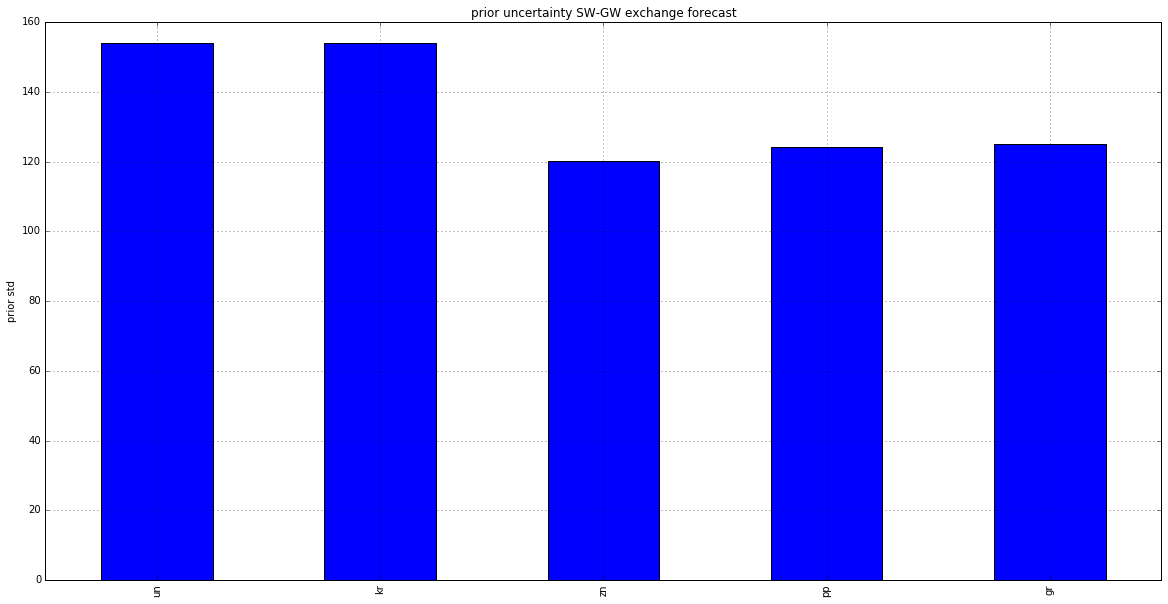

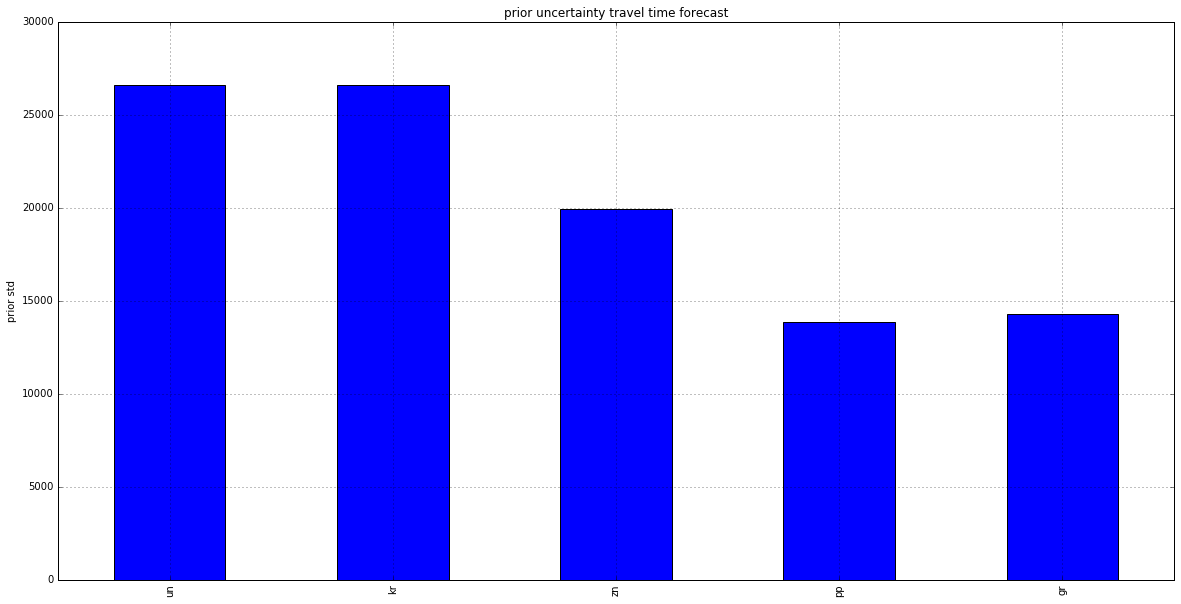

In [8]:
for forecast,title in zip(forecasts,titles):
    ax = prior.loc[forecast,:].plot(kind="bar",figsize=(20,10))
    ax.set_ylabel("prior std")
    ax.set_title("prior uncertainty {0} forecast".format(title))
    ax.grid()
    plt.show()

## Posterior uncertainty

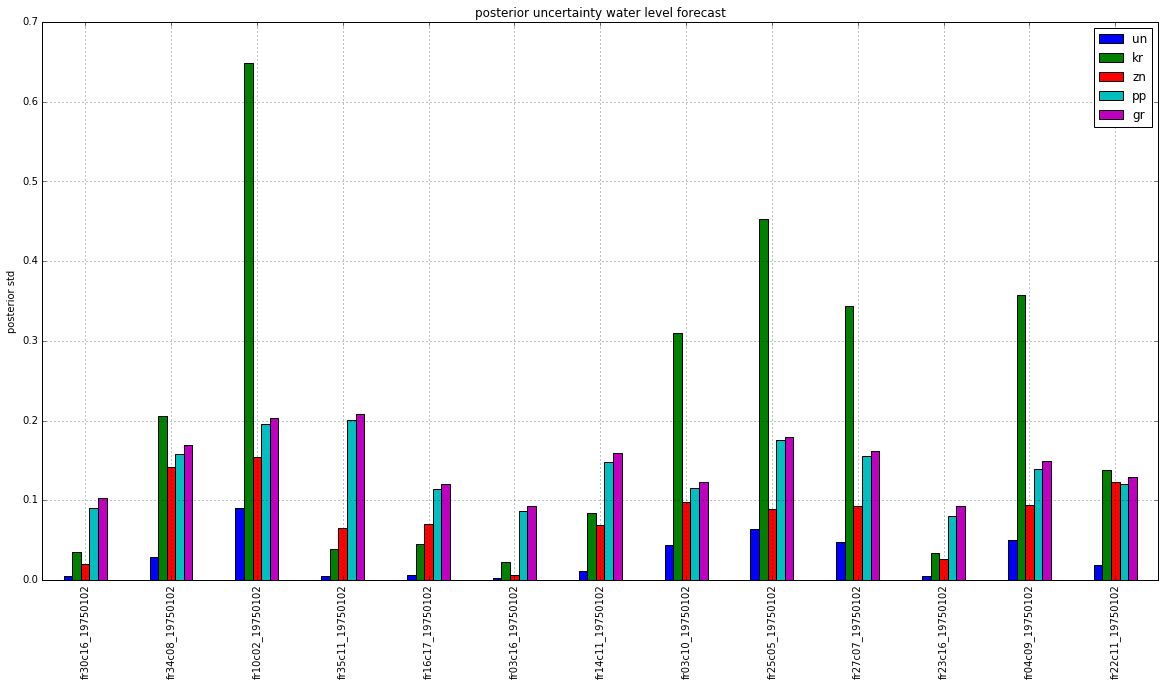

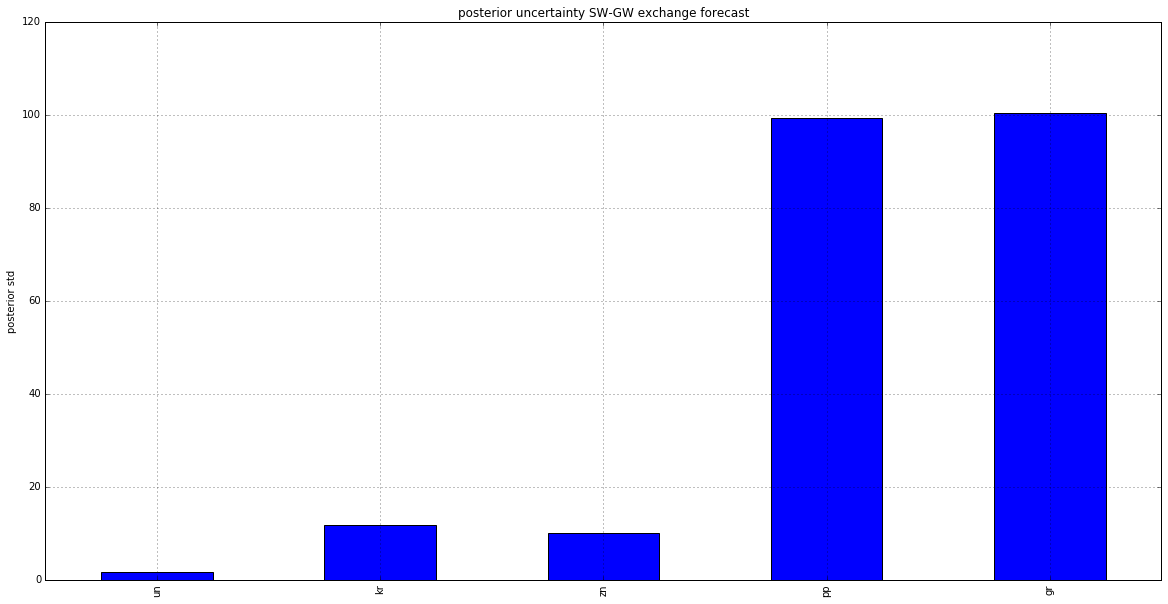

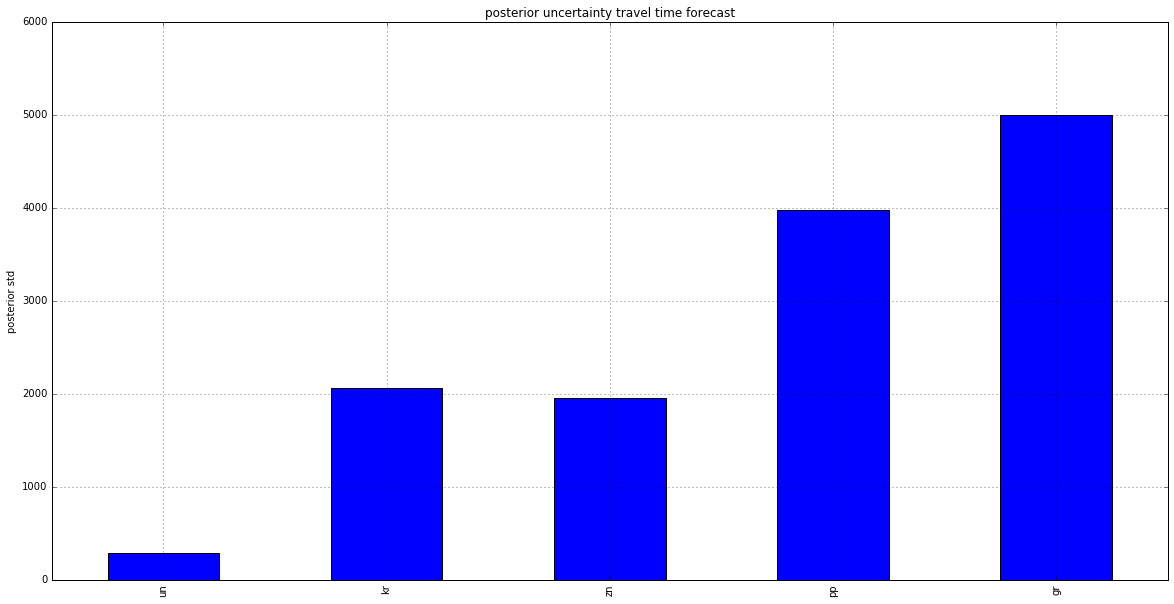

In [9]:
for forecast,title in zip(forecasts,titles):
    ax = post.loc[forecast,:].plot(kind="bar",figsize=(20,10))
    ax.set_ylabel("posterior std")
    ax.set_title("posterior uncertainty {0} forecast".format(title))
    ax.grid()
    plt.show()

# Monte Carlo comparison

We will use rejection sampling for the K, K + R, and Zone case, Schur-based posterior sampling for pilot points and iES for the grid scale model. We will allow approximately 1000 runs for each case - since the pilot points schur posterior sampling requires the best-fit par values, we burn 500 runs "calibrating" this model...

In [10]:
for pst_name, wd in zip(pst_names[:3],working_dirs[:3]):
    pst = pyemu.Pst(os.path.join(wd,pst_name))
    mc = pyemu.MonteCarlo(pst=pst)
    mc.draw(1000)
    mc.parensemble.to_csv(os.path.join(wd,"sweep_in.csv"))
    pyemu.helpers.start_slaves(wd,"sweep",pst_name,num_slaves=20,master_dir=wd+"_master")

master:sweep freyberg_un.pst /h :4004 in freyberg_un_master
slave:sweep freyberg_un.pst /h localhost:4004 in ..\slave_0
slave:sweep freyberg_un.pst /h localhost:4004 in ..\slave_1
slave:sweep freyberg_un.pst /h localhost:4004 in ..\slave_2
slave:sweep freyberg_un.pst /h localhost:4004 in ..\slave_3
slave:sweep freyberg_un.pst /h localhost:4004 in ..\slave_4
slave:sweep freyberg_un.pst /h localhost:4004 in ..\slave_5
slave:sweep freyberg_un.pst /h localhost:4004 in ..\slave_6
slave:sweep freyberg_un.pst /h localhost:4004 in ..\slave_7
slave:sweep freyberg_un.pst /h localhost:4004 in ..\slave_8
slave:sweep freyberg_un.pst /h localhost:4004 in ..\slave_9
slave:sweep freyberg_un.pst /h localhost:4004 in ..\slave_10
slave:sweep freyberg_un.pst /h localhost:4004 in ..\slave_11
slave:sweep freyberg_un.pst /h localhost:4004 in ..\slave_12
slave:sweep freyberg_un.pst /h localhost:4004 in ..\slave_13
slave:sweep freyberg_un.pst /h localhost:4004 in ..\slave_14
slave:sweep freyberg_un.pst /h loca

In [11]:
pst = pyemu.Pst(os.path.join(fs.WORKING_DIR_PP,fs.PST_NAME_PP))
pst.control_data.noptmax = 8
pst.pestpp_options["n_iter_base"] = -1
pst.pestpp_options["n_iter_super"] = 3
pst.write(os.path.join(fs.WORKING_DIR_PP,fs.PST_NAME_PP))
pyemu.helpers.start_slaves(fs.WORKING_DIR_PP,"pestpp",fs.PST_NAME_PP
                           ,num_slaves=15,master_dir=fs.WORKING_DIR_PP+"_master")

master:pestpp freyberg_pp.pst /h :4004 in freyberg_pp_master
slave:pestpp freyberg_pp.pst /h localhost:4004 in ..\slave_0
slave:pestpp freyberg_pp.pst /h localhost:4004 in ..\slave_1
slave:pestpp freyberg_pp.pst /h localhost:4004 in ..\slave_2
slave:pestpp freyberg_pp.pst /h localhost:4004 in ..\slave_3
slave:pestpp freyberg_pp.pst /h localhost:4004 in ..\slave_4
slave:pestpp freyberg_pp.pst /h localhost:4004 in ..\slave_5
slave:pestpp freyberg_pp.pst /h localhost:4004 in ..\slave_6
slave:pestpp freyberg_pp.pst /h localhost:4004 in ..\slave_7
slave:pestpp freyberg_pp.pst /h localhost:4004 in ..\slave_8
slave:pestpp freyberg_pp.pst /h localhost:4004 in ..\slave_9
slave:pestpp freyberg_pp.pst /h localhost:4004 in ..\slave_10
slave:pestpp freyberg_pp.pst /h localhost:4004 in ..\slave_11
slave:pestpp freyberg_pp.pst /h localhost:4004 in ..\slave_12
slave:pestpp freyberg_pp.pst /h localhost:4004 in ..\slave_13
slave:pestpp freyberg_pp.pst /h localhost:4004 in ..\slave_14


In [12]:
pst = pyemu.Pst(os.path.join(fs.WORKING_DIR_PP+"_master",fs.PST_NAME_PP))
pst.adjust_weights_resfile()
mc = pyemu.MonteCarlo(pst=pst,parcov=fs.build_prior_pp())
mc.draw(500)
mc.parensemble.to_csv(os.path.join(fs.WORKING_DIR_PP,"sweep_in.csv"))
pyemu.helpers.start_slaves(fs.WORKING_DIR_PP,"sweep",fs.PST_NAME_PP
                           ,num_slaves=15,master_dir=fs.WORKING_DIR_PP+"_master")

master:sweep freyberg_pp.pst /h :4004 in freyberg_pp_master
slave:sweep freyberg_pp.pst /h localhost:4004 in ..\slave_0
slave:sweep freyberg_pp.pst /h localhost:4004 in ..\slave_1
slave:sweep freyberg_pp.pst /h localhost:4004 in ..\slave_2
slave:sweep freyberg_pp.pst /h localhost:4004 in ..\slave_3
slave:sweep freyberg_pp.pst /h localhost:4004 in ..\slave_4
slave:sweep freyberg_pp.pst /h localhost:4004 in ..\slave_5
slave:sweep freyberg_pp.pst /h localhost:4004 in ..\slave_6
slave:sweep freyberg_pp.pst /h localhost:4004 in ..\slave_7
slave:sweep freyberg_pp.pst /h localhost:4004 in ..\slave_8
slave:sweep freyberg_pp.pst /h localhost:4004 in ..\slave_9
slave:sweep freyberg_pp.pst /h localhost:4004 in ..\slave_10
slave:sweep freyberg_pp.pst /h localhost:4004 in ..\slave_11
slave:sweep freyberg_pp.pst /h localhost:4004 in ..\slave_12
slave:sweep freyberg_pp.pst /h localhost:4004 in ..\slave_13
slave:sweep freyberg_pp.pst /h localhost:4004 in ..\slave_14


In [13]:
gr_prior = fs.build_prior_gr()
os.chdir(fs.WORKING_DIR_GR+"_master")
pst = pyemu.Pst(fs.PST_NAME_GR)
ies = pyemu.EnsembleSmoother(pst=pst,num_slaves=15,slave_dir=os.path.join("..",fs.WORKING_DIR_GR),
                             port=4005,parcov=gr_prior,verbose="ies.log")
ies.initialize(num_reals=100)
for _ in range(4):
    ies.update()
os.chdir("..")

E:\miniconda\lib\site-packages\pandas\core\indexing.py:288: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
E:\miniconda\lib\site-packages\pandas\core\indexing.py:465: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


2017-09-06 11:01:56.226791 starting: initializing smoother with 100 realizations
2017-09-06 11:01:56.226791 starting: initializing parensemble
2017-09-06 11:02:00.435389 finished: initializing parensemble took: 0:00:04.208598
2017-09-06 11:02:00.647804 starting: initializing parensemble
2017-09-06 11:02:00.647804 starting: initializing obsensemble
2017-09-06 11:02:02.668339 finished: initializing obsensemble took: 0:00:02.020535
2017-09-06 11:02:02.669340 finished: initializing smoother with 100 realizations took: 0:00:06.442549
2017-09-06 11:02:02.733772 starting: evaluating initial ensembles
2017-09-06 11:02:02.733772 starting: removing existing sweep in/out files
2017-09-06 11:02:02.733772 WARNING: error removing existing sweep in file:[WinError 2] The system cannot find the file specified: 'sweep_in.csv'
2017-09-06 11:02:02.734773 WARNING: error removing existing sweep out file:[WinError 2] The system cannot find the file specified: 'sweep_out.csv'
2017-09-06 11:02:02.734773 finish

In [14]:
os.getcwd()

'E:\\git\\GW1876\\activities\\freyberg_summary'

In [48]:
dfs = []
for pst_name,wd in zip(pst_names,working_dirs):
    df = pd.read_csv(os.path.join(wd+"_master","sweep_out.csv"),index_col=0)
    df.columns = [c.lower() for c in df.columns]
    df = df.loc[df.failed_flag==0,:]
    dfs.append(df)

(986,)
(987,)
(998,)
(500,)
(100,)


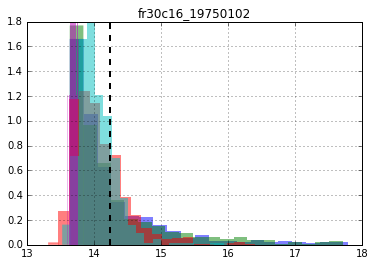

(882,)
(871,)
(979,)
(500,)
(100,)


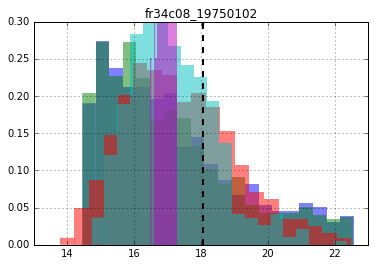

(731,)
(733,)
(819,)
(469,)
(100,)


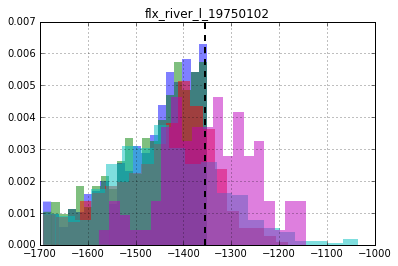

(634,)
(647,)
(724,)
(414,)
(100,)


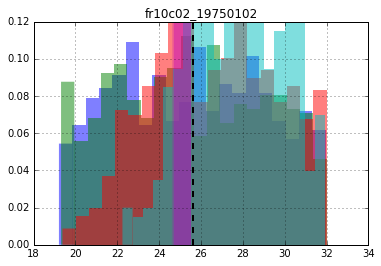

(945,)
(950,)
(997,)
(500,)
(100,)


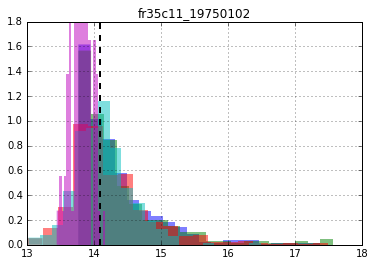

(962,)
(967,)
(993,)
(500,)
(100,)


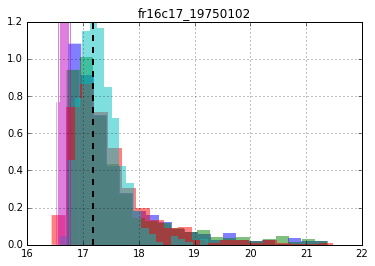

(196,)
(194,)
(248,)
(143,)
(0,)


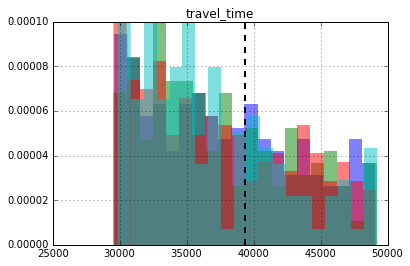

(994,)
(994,)
(998,)
(500,)
(100,)


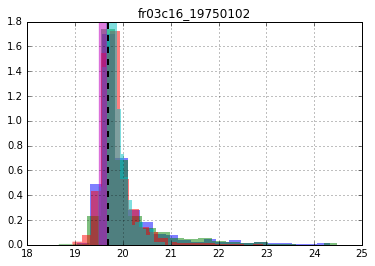

(938,)
(933,)
(983,)
(500,)
(100,)


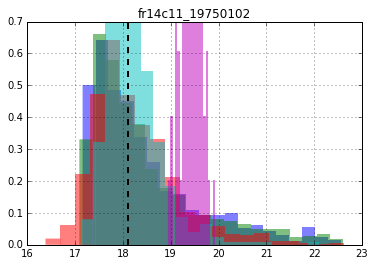

(770,)
(773,)
(817,)
(476,)
(100,)


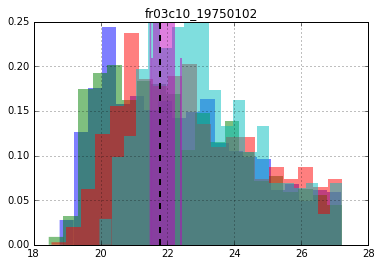

(706,)
(722,)
(829,)
(473,)
(100,)


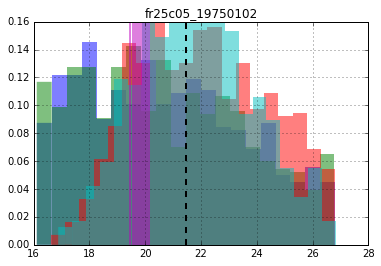

(792,)
(788,)
(937,)
(494,)
(100,)


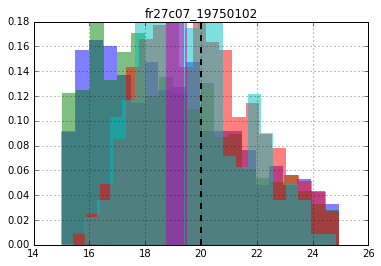

(986,)
(987,)
(997,)
(500,)
(100,)


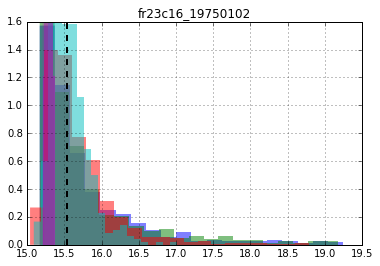

(743,)
(752,)
(786,)
(464,)
(100,)


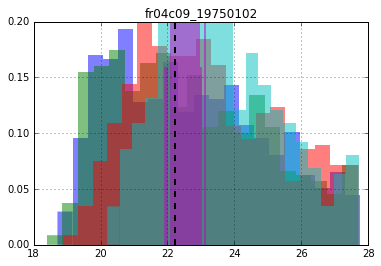

(904,)
(894,)
(977,)
(500,)
(100,)


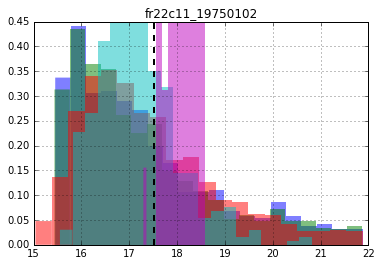

In [55]:
for forecast in prior.index.values:
    ax = plt.subplot(111)
    ax.set_title(forecast)
    mnmx = 1.0e+10
    v = pst.observation_data.loc[forecast,"obsval"]
    for df,pst_name in zip(dfs,pst_names):
        #print(df)
        
        f = df.loc[:,forecast].copy()
        #print(np.abs(f - v) / np.abs(v))
        #break
        f = f.loc[(np.abs(f - v))/np.abs(v) < .25]
        print(f.shape)
        #df.loc[:,forecast].hist(bins=20,ax=ax,alpha=0.5,normed=True,edgecolor="none",
        #                        label=pst_name.split('.')[0].split('_')[1])
        a = f.hist(bins=20,ax=ax,alpha=0.5,normed=True,edgecolor="none",
                               label=pst_name.split('.')[0].split('_')[1])
        ylim = ax.get_ylim()
        mnmx = min(ylim[1],mnmx)
       
    
    
    ax.plot([v,v],[0,mnmx],"k--",lw=2.0)
    ax.set_ylim(0,mnmx)    
    plt.show()
    